# EEG Seizure Detection Pipeline

This notebook implements the seizure detection pipeline based on the flowchart design.

## Pipeline Overview
1. EEG Signal Input
2. Preprocessing & Artifact Removal
3. Channel Localization
4. Hemisphere Determination
5. Signal Analysis
6. Feature Extraction (Frequency, Time, Amplitude & Power)
7. Compare to Seizure Prototypes
8. Pattern Matching & Similarity Scoring
9. Seizure Detection & Classification
10. Output Results

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.stats import kurtosis, skew
import pandas as pd
from datetime import datetime
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Import our existing EDFConverter
from edf_converter import EDFConverter

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## Configuration - Easy Algorithm Selection

Modify these dictionaries to switch between different algorithms

In [2]:
# Algorithm Configuration
CONFIG = {
    # Preprocessing algorithms
    'preprocessing': {
        'filter_type': 'butterworth',  # Options: 'butterworth', 'fir', 'iir'
        'lowpass_freq': 40.0,  # Hz
        'highpass_freq': 0.5,  # Hz
        'notch_freq': 60.0,  # Hz (50 for Europe, 60 for US)
        'artifact_removal': 'ica',  # Options: 'ica', 'regression', 'threshold'
    },
    
    # Feature extraction methods
    'feature_extraction': {
        'frequency_method': 'welch',  # Options: 'welch', 'fft', 'multitaper'
        'time_features': ['mean', 'std', 'kurtosis', 'skewness', 'line_length'],
        'frequency_bands': {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'gamma': (30, 40)
        }
    },
    
    # Pattern matching algorithm
    'pattern_matching': {
        'algorithm': 'cosine_similarity',  # Options: 'cosine_similarity', 'euclidean', 'dtw', 'correlation'
        'window_size': 5.0,  # seconds
        'overlap': 0.5  # 50% overlap
    },
    
    # Detection thresholds
    'thresholds': {
        'high_confidence': 0.80,
        'medium_confidence': 0.50,
        'low_confidence': 0.20
    }
}

print("Configuration loaded:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration loaded:
  preprocessing: {'filter_type': 'butterworth', 'lowpass_freq': 40.0, 'highpass_freq': 0.5, 'notch_freq': 60.0, 'artifact_removal': 'ica'}
  feature_extraction: {'frequency_method': 'welch', 'time_features': ['mean', 'std', 'kurtosis', 'skewness', 'line_length'], 'frequency_bands': {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30), 'gamma': (30, 40)}}
  pattern_matching: {'algorithm': 'cosine_similarity', 'window_size': 5.0, 'overlap': 0.5}
  thresholds: {'high_confidence': 0.8, 'medium_confidence': 0.5, 'low_confidence': 0.2}


## 1. EEG Signal Input

### Data Input Options:
- **Option A**: Load from EDF file using EDFConverter
- **Option B**: Load from preprocessed NumPy array
- **Option C**: Use placeholder data for testing

**TODO**: Replace with your actual data when available

In [3]:
class EEGDataLoader:
    """Flexible data loader for EEG signals"""
    
    def __init__(self):
        self.data = None
        self.times = None
        self.channel_names = None
        self.sfreq = None
        self.info = None
    
    def load_from_edf(self, filepath: str, channels: Optional[List[str]] = None):
        """Load data from EDF file"""
        converter = EDFConverter(filepath)
        self.data, self.times = converter.get_data(channels=channels)
        info = converter.get_info()
        self.channel_names = info['channel_names']
        self.sfreq = info['sampling_rate']
        self.info = info
        print(f"✓ Loaded EDF: {info['n_channels']} channels, {info['duration']:.2f}s duration")
        return self
    
    def load_from_numpy(self, data: np.ndarray, sfreq: float, 
                       channel_names: Optional[List[str]] = None):
        """Load data from NumPy array"""
        self.data = data
        self.sfreq = sfreq
        self.times = np.arange(data.shape[1]) / sfreq
        self.channel_names = channel_names or [f"Ch{i+1}" for i in range(data.shape[0])]
        print(f"✓ Loaded NumPy array: {data.shape[0]} channels, {self.times[-1]:.2f}s duration")
        return self
    
    def load_from_database(self, patient_id: str, session_id: str):
        """Load data from your database - IMPLEMENT THIS when data is ready"""
        # TODO: Implement database loading logic
        # Example structure:
        # data = your_database.query(patient_id, session_id)
        # self.data = data['signals']
        # self.sfreq = data['sampling_rate']
        # self.channel_names = data['channels']
        # self.times = data['timestamps']
        
        raise NotImplementedError("Database loading not yet implemented")
    
    def create_sample_data(self, n_channels: int = 19, duration: float = 30.0, 
                          sfreq: float = 256.0, add_seizure: bool = False):
        """Create sample data for testing"""
        n_samples = int(duration * sfreq)
        self.sfreq = sfreq
        self.times = np.arange(n_samples) / sfreq
        
        # Generate synthetic EEG-like signals
        self.data = np.zeros((n_channels, n_samples))
        for i in range(n_channels):
            # Background EEG (alpha rhythm + noise)
            alpha = 0.5 * np.sin(2 * np.pi * 10 * self.times)  # 10 Hz alpha
            noise = 0.2 * np.random.randn(n_samples)
            self.data[i] = alpha + noise
            
            # Add seizure activity if requested
            if add_seizure and 10 < self.times[-1] < 20:
                seizure_start = int(10 * sfreq)
                seizure_end = int(20 * sfreq)
                # High frequency spike activity
                spike = 2.0 * np.sin(2 * np.pi * 20 * self.times[seizure_start:seizure_end])
                self.data[i, seizure_start:seizure_end] += spike
        
        self.channel_names = [f"EEG{i+1}" for i in range(n_channels)]
        print(f"✓ Created sample data: {n_channels} channels, {duration:.2f}s duration")
        if add_seizure:
            print("  Synthetic seizure added at 10-20s")
        return self

# Initialize data loader
loader = EEGDataLoader()

# ===== CHOOSE YOUR DATA INPUT METHOD =====
# Uncomment ONE of the following:

# Option A: Load from EDF file
# loader.load_from_edf('path/to/your/file.edf')

# Option B: Load from NumPy array (when you have preprocessed data)
# your_data = np.load('your_data.npy')
# loader.load_from_numpy(your_data, sfreq=256.0)

# Option C: Use sample data for testing (DEFAULT)
loader.create_sample_data(n_channels=19, duration=30.0, add_seizure=True)

# Option D: Load from database (implement when ready)
# loader.load_from_database(patient_id='P001', session_id='S001')

print(f"\nData shape: {loader.data.shape}")
print(f"Sampling rate: {loader.sfreq} Hz")
print(f"Duration: {loader.times[-1]:.2f} seconds")

✓ Created sample data: 19 channels, 30.00s duration
  Synthetic seizure added at 10-20s

Data shape: (19, 7680)
Sampling rate: 256.0 Hz
Duration: 30.00 seconds


## 2. Preprocessing & Artifact Removal

Preprocessing...
  Bandpass filter: 0.5-40.0 Hz
  Notch filter: 60.0 Hz
  Using ICA artifact removal (placeholder)
✓ Preprocessing complete


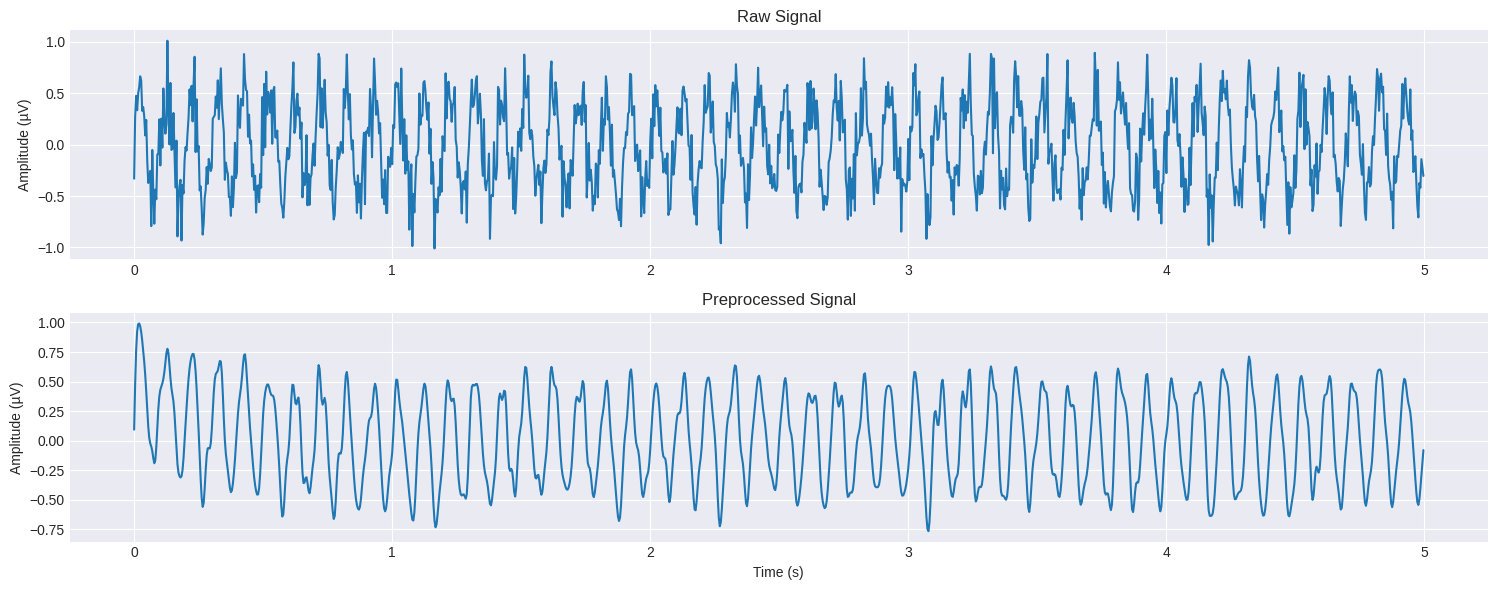

In [4]:
class Preprocessor:
    """Preprocessing and artifact removal"""
    
    def __init__(self, config: Dict):
        self.config = config
    
    def bandpass_filter(self, data: np.ndarray, sfreq: float) -> np.ndarray:
        """Apply bandpass filter"""
        low = self.config['highpass_freq']
        high = self.config['lowpass_freq']
        nyq = sfreq / 2
        
        if self.config['filter_type'] == 'butterworth':
            sos = signal.butter(4, [low/nyq, high/nyq], btype='band', output='sos')
            filtered = signal.sosfiltfilt(sos, data, axis=1)
        else:
            # Add other filter types here
            filtered = data
        
        return filtered
    
    def notch_filter(self, data: np.ndarray, sfreq: float) -> np.ndarray:
        """Remove powerline noise"""
        notch_freq = self.config['notch_freq']
        Q = 30  # Quality factor
        b, a = signal.iirnotch(notch_freq, Q, sfreq)
        filtered = signal.filtfilt(b, a, data, axis=1)
        return filtered
    
    def remove_artifacts(self, data: np.ndarray, sfreq: float) -> np.ndarray:
        """Remove artifacts - placeholder for different methods"""
        method = self.config['artifact_removal']
        
        if method == 'ica':
            # Placeholder for ICA-based artifact removal
            # TODO: Implement full ICA when needed
            print("  Using ICA artifact removal (placeholder)")
            return data
        
        elif method == 'threshold':
            # Simple threshold-based artifact rejection
            threshold = 5 * np.std(data)
            data_clean = data.copy()
            data_clean[np.abs(data) > threshold] = np.nan
            # Interpolate NaN values
            for ch in range(data_clean.shape[0]):
                mask = np.isnan(data_clean[ch])
                if mask.any():
                    data_clean[ch][mask] = np.interp(
                        np.where(mask)[0], 
                        np.where(~mask)[0], 
                        data_clean[ch][~mask]
                    )
            return data_clean
        
        else:
            print(f"  Artifact removal method '{method}' not implemented")
            return data
    
    def preprocess(self, data: np.ndarray, sfreq: float) -> np.ndarray:
        """Full preprocessing pipeline"""
        print("Preprocessing...")
        data_clean = data.copy()
        
        # Apply filters
        print(f"  Bandpass filter: {self.config['highpass_freq']}-{self.config['lowpass_freq']} Hz")
        data_clean = self.bandpass_filter(data_clean, sfreq)
        
        print(f"  Notch filter: {self.config['notch_freq']} Hz")
        data_clean = self.notch_filter(data_clean, sfreq)
        
        # Remove artifacts
        data_clean = self.remove_artifacts(data_clean, sfreq)
        
        print("✓ Preprocessing complete")
        return data_clean

# Apply preprocessing
preprocessor = Preprocessor(CONFIG['preprocessing'])
data_clean = preprocessor.preprocess(loader.data, loader.sfreq)

# Visualize before/after
fig, axes = plt.subplots(2, 1, figsize=(15, 6))
ch_idx = 0  # Show first channel
time_window = (0, 5)  # First 5 seconds
idx_start = int(time_window[0] * loader.sfreq)
idx_end = int(time_window[1] * loader.sfreq)

axes[0].plot(loader.times[idx_start:idx_end], loader.data[ch_idx, idx_start:idx_end])
axes[0].set_title('Raw Signal')
axes[0].set_ylabel('Amplitude (µV)')

axes[1].plot(loader.times[idx_start:idx_end], data_clean[ch_idx, idx_start:idx_end])
axes[1].set_title('Preprocessed Signal')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude (µV)')

plt.tight_layout()
plt.show()

## 3. Channel Localization & Hemisphere Determination

In [5]:
class ChannelLocalizer:
    """Determine hemisphere and localization of channels"""
    
    # Standard 10-20 system hemisphere mapping
    HEMISPHERE_MAP = {
        'left': ['F7', 'F3', 'T3', 'T7', 'C3', 'T5', 'P3', 'O1', 'Fp1', 'A1'],
        'right': ['F8', 'F4', 'T4', 'T8', 'C4', 'T6', 'P4', 'O2', 'Fp2', 'A2'],
        'midline': ['Fz', 'Cz', 'Pz', 'Oz']
    }
    
    def __init__(self, channel_names: List[str]):
        self.channel_names = channel_names
        self.localization = self._localize_channels()
    
    def _localize_channels(self) -> Dict[str, List[int]]:
        """Map channels to hemispheres"""
        localization = {'left': [], 'right': [], 'midline': [], 'unknown': []}
        
        for idx, ch_name in enumerate(self.channel_names):
            # Check against standard positions
            found = False
            for hemisphere, positions in self.HEMISPHERE_MAP.items():
                if any(pos in ch_name.upper() for pos in positions):
                    localization[hemisphere].append(idx)
                    found = True
                    break
            
            if not found:
                # Try to infer from naming conventions
                if any(x in ch_name for x in ['1', '3', '5', '7']) and 'L' not in ch_name:
                    localization['left'].append(idx)
                elif any(x in ch_name for x in ['2', '4', '6', '8']) and 'R' not in ch_name:
                    localization['right'].append(idx)
                else:
                    localization['unknown'].append(idx)
        
        return localization
    
    def determine_hemisphere(self, data: np.ndarray, window: Tuple[int, int]) -> str:
        """Determine which hemisphere(s) show activity in time window"""
        start_idx, end_idx = window
        
        # Calculate power in each hemisphere
        left_power = 0
        right_power = 0
        
        for idx in self.localization['left']:
            left_power += np.sum(data[idx, start_idx:end_idx] ** 2)
        
        for idx in self.localization['right']:
            right_power += np.sum(data[idx, start_idx:end_idx] ** 2)
        
        # Normalize by number of channels
        if len(self.localization['left']) > 0:
            left_power /= len(self.localization['left'])
        if len(self.localization['right']) > 0:
            right_power /= len(self.localization['right'])
        
        # Determine dominance
        ratio = left_power / (right_power + 1e-10)
        
        if 0.7 < ratio < 1.3:  # Both hemispheres involved
            return 'bilateral'
        elif ratio > 1.3:
            return 'left'
        else:
            return 'right'
    
    def get_hemisphere_channels(self, hemisphere: str) -> Tuple[List[int], List[str]]:
        """Get channel indices and names for a hemisphere"""
        if hemisphere == 'bilateral':
            indices = self.localization['left'] + self.localization['right']
        else:
            indices = self.localization[hemisphere]
        
        names = [self.channel_names[i] for i in indices]
        return indices, names

# Initialize channel localizer
localizer = ChannelLocalizer(loader.channel_names)

print("Channel Localization:")
for hemisphere, indices in localizer.localization.items():
    if indices:
        channels = [loader.channel_names[i] for i in indices]
        print(f"  {hemisphere.capitalize()}: {len(indices)} channels - {channels[:5]}...")

# Test hemisphere determination on a window
test_window = (int(15 * loader.sfreq), int(16 * loader.sfreq))  # 15-16 seconds
hemisphere = localizer.determine_hemisphere(data_clean, test_window)
print(f"\nTest window (15-16s) hemisphere: {hemisphere}")

Channel Localization:
  Left: 14 channels - ['EEG1', 'EEG3', 'EEG5', 'EEG7', 'EEG10']...
  Right: 4 channels - ['EEG2', 'EEG4', 'EEG6', 'EEG8']...
  Unknown: 1 channels - ['EEG9']...

Test window (15-16s) hemisphere: bilateral


## 4. Signal Analysis Module - Feature Extraction

Extract features from three domains:
- **Frequency Domain**: Power spectral density, band powers
- **Time Domain**: Statistical features, morphology
- **Amplitude & Power**: Peak detection, energy

In [6]:
class FeatureExtractor:
    """Extract features from EEG signals"""
    
    def __init__(self, config: Dict, sfreq: float):
        self.config = config
        self.sfreq = sfreq
        self.bands = config['frequency_bands']
    
    def extract_frequency_features(self, data: np.ndarray) -> Dict[str, np.ndarray]:
        """Extract frequency domain features"""
        features = {}
        method = self.config['frequency_method']
        
        for ch_idx in range(data.shape[0]):
            if method == 'welch':
                freqs, psd = signal.welch(data[ch_idx], fs=self.sfreq, nperseg=min(256, len(data[ch_idx])//2))
            elif method == 'fft':
                fft_vals = fft(data[ch_idx])
                freqs = fftfreq(len(data[ch_idx]), 1/self.sfreq)
                psd = np.abs(fft_vals) ** 2
            else:
                # Default to welch
                freqs, psd = signal.welch(data[ch_idx], fs=self.sfreq)
            
            # Calculate band powers
            for band_name, (low, high) in self.bands.items():
                band_mask = (freqs >= low) & (freqs <= high)
                band_power = np.trapz(psd[band_mask], freqs[band_mask])
                
                if ch_idx == 0:
                    features[f'{band_name}_power'] = []
                features[f'{band_name}_power'].append(band_power)
        
        # Convert to arrays
        for key in features:
            features[key] = np.array(features[key])
        
        # Add spectral edge frequency
        features['spectral_edge'] = np.array([freqs[np.where(np.cumsum(psd)/np.sum(psd) > 0.95)[0][0]] 
                                              for ch_idx in range(data.shape[0])])
        
        return features
    
    def extract_time_features(self, data: np.ndarray) -> Dict[str, np.ndarray]:
        """Extract time domain features"""
        features = {}
        requested = self.config['time_features']
        
        if 'mean' in requested:
            features['mean'] = np.mean(data, axis=1)
        
        if 'std' in requested:
            features['std'] = np.std(data, axis=1)
        
        if 'kurtosis' in requested:
            features['kurtosis'] = kurtosis(data, axis=1)
        
        if 'skewness' in requested:
            features['skewness'] = skew(data, axis=1)
        
        if 'line_length' in requested:
            # Line length: sum of absolute differences
            features['line_length'] = np.sum(np.abs(np.diff(data, axis=1)), axis=1)
        
        if 'zero_crossings' in requested:
            features['zero_crossings'] = np.sum(np.diff(np.sign(data), axis=1) != 0, axis=1)
        
        return features
    
    def extract_amplitude_power_features(self, data: np.ndarray) -> Dict[str, np.ndarray]:
        """Extract amplitude and power features"""
        features = {}
        
        # Peak-to-peak amplitude
        features['peak_to_peak'] = np.ptp(data, axis=1)
        
        # RMS (root mean square) - measure of signal power
        features['rms'] = np.sqrt(np.mean(data ** 2, axis=1))
        
        # Energy
        features['energy'] = np.sum(data ** 2, axis=1)
        
        # Peak amplitude
        features['max_amplitude'] = np.max(np.abs(data), axis=1)
        
        return features
    
    def extract_all_features(self, data: np.ndarray) -> pd.DataFrame:
        """Extract all features and return as DataFrame"""
        all_features = {}
        
        # Frequency domain
        freq_features = self.extract_frequency_features(data)
        all_features.update(freq_features)
        
        # Time domain
        time_features = self.extract_time_features(data)
        all_features.update(time_features)
        
        # Amplitude & Power
        amp_features = self.extract_amplitude_power_features(data)
        all_features.update(amp_features)
        
        # Create DataFrame
        df = pd.DataFrame(all_features)
        return df

# Extract features from a window
extractor = FeatureExtractor(CONFIG['feature_extraction'], loader.sfreq)

# Extract features from 15-20 second window (where we added synthetic seizure)
window_start = int(15 * loader.sfreq)
window_end = int(20 * loader.sfreq)
window_data = data_clean[:, window_start:window_end]

features_df = extractor.extract_all_features(window_data)
print("\nExtracted Features (15-20s window):")
print(features_df.head())
print(f"\nTotal features extracted: {len(features_df.columns)}")
print(f"Feature names: {list(features_df.columns)}")


Extracted Features (15-20s window):
   delta_power  theta_power  alpha_power  beta_power  gamma_power  \
0     0.000854     0.001159     0.129190    0.004767     0.001566   
1     0.000977     0.001643     0.130437    0.004433     0.001396   
2     0.001077     0.001229     0.129232    0.006228     0.001455   
3     0.000918     0.001435     0.123409    0.004949     0.001690   
4     0.000916     0.001437     0.123078    0.005343     0.001965   

   spectral_edge      mean       std  kurtosis  skewness  line_length  \
0           17.0  0.001081  0.373526 -1.274432  0.001338   110.604311   
1           17.0  0.000800  0.373741 -1.276500 -0.043051   110.775310   
2           17.0 -0.001647  0.371824 -1.271987  0.019715   110.218533   
3           17.0  0.000689  0.364105 -1.257123 -0.002682   109.706400   
4           17.0 -0.000309  0.367931 -1.287208 -0.026511   110.210568   

   peak_to_peak       rms      energy  max_amplitude  
0      1.526023  0.373527  178.588815       0.805236  

## 5. Seizure Prototype Database

Define characteristic features for different seizure types

In [7]:
class SeizurePrototypeDatabase:
    """Database of seizure type prototypes"""
    
    def __init__(self):
        self.prototypes = self._initialize_prototypes()
    
    def _initialize_prototypes(self) -> Dict[str, Dict]:
        """Initialize seizure prototypes with characteristic features
        
        TODO: Replace these with learned prototypes from your actual data
        """
        return {
            'generalized_tonic_clonic': {
                'description': 'Generalized Tonic-Clonic (Grand Mal)',
                'features': {
                    'delta_power': {'mean': 2.5, 'std': 0.5, 'weight': 1.0},
                    'theta_power': {'mean': 2.0, 'std': 0.4, 'weight': 1.0},
                    'alpha_power': {'mean': 1.0, 'std': 0.3, 'weight': 0.8},
                    'beta_power': {'mean': 1.5, 'std': 0.4, 'weight': 1.0},
                    'gamma_power': {'mean': 0.5, 'std': 0.2, 'weight': 0.7},
                    'rms': {'mean': 150, 'std': 30, 'weight': 1.0},
                    'line_length': {'mean': 5000, 'std': 1000, 'weight': 0.9},
                },
                'hemisphere': 'bilateral',
                'duration_range': (60, 180),  # seconds
            },
            
            'absence': {
                'description': 'Absence Seizure (Petit Mal)',
                'features': {
                    'delta_power': {'mean': 0.5, 'std': 0.2, 'weight': 0.7},
                    'theta_power': {'mean': 3.0, 'std': 0.5, 'weight': 1.5},  # 3 Hz spike-wave
                    'alpha_power': {'mean': 0.5, 'std': 0.2, 'weight': 0.5},
                    'beta_power': {'mean': 0.3, 'std': 0.1, 'weight': 0.5},
                    'rms': {'mean': 50, 'std': 15, 'weight': 0.8},
                },
                'hemisphere': 'bilateral',
                'duration_range': (5, 20),
            },
            
            'focal_partial': {
                'description': 'Focal/Partial Seizure',
                'features': {
                    'delta_power': {'mean': 1.5, 'std': 0.4, 'weight': 0.8},
                    'theta_power': {'mean': 1.8, 'std': 0.4, 'weight': 1.0},
                    'alpha_power': {'mean': 1.2, 'std': 0.3, 'weight': 0.7},
                    'beta_power': {'mean': 2.0, 'std': 0.5, 'weight': 1.2},
                    'gamma_power': {'mean': 1.5, 'std': 0.4, 'weight': 1.0},
                    'rms': {'mean': 100, 'std': 25, 'weight': 0.9},
                },
                'hemisphere': 'unilateral',  # Can be left or right
                'duration_range': (30, 120),
            },
            
            'myoclonic': {
                'description': 'Myoclonic Seizure',
                'features': {
                    'delta_power': {'mean': 0.8, 'std': 0.3, 'weight': 0.6},
                    'theta_power': {'mean': 1.0, 'std': 0.3, 'weight': 0.7},
                    'alpha_power': {'mean': 0.7, 'std': 0.2, 'weight': 0.5},
                    'beta_power': {'mean': 1.5, 'std': 0.4, 'weight': 1.0},
                    'gamma_power': {'mean': 2.0, 'std': 0.5, 'weight': 1.5},  # High frequency
                    'peak_to_peak': {'mean': 200, 'std': 50, 'weight': 1.2},
                    'rms': {'mean': 80, 'std': 20, 'weight': 0.8},
                },
                'hemisphere': 'bilateral',
                'duration_range': (1, 5),  # Very brief
            },
            
            'atonic': {
                'description': 'Atonic Seizure (Drop Attack)',
                'features': {
                    'delta_power': {'mean': 2.0, 'std': 0.5, 'weight': 1.2},
                    'theta_power': {'mean': 1.5, 'std': 0.4, 'weight': 1.0},
                    'alpha_power': {'mean': 0.3, 'std': 0.1, 'weight': 0.5},
                    'beta_power': {'mean': 0.2, 'std': 0.1, 'weight': 0.4},
                    'rms': {'mean': 60, 'std': 15, 'weight': 0.7},
                },
                'hemisphere': 'bilateral',
                'duration_range': (5, 20),
            },
        }
    
    def load_prototypes_from_file(self, filepath: str):
        """Load learned prototypes from file - IMPLEMENT THIS
        
        TODO: Once you have trained models or learned prototypes,
        implement loading them from a file (JSON, pickle, etc.)
        """
        # Example: self.prototypes = json.load(open(filepath))
        raise NotImplementedError("Prototype loading not yet implemented")
    
    def get_prototype(self, seizure_type: str) -> Dict:
        """Get prototype for a specific seizure type"""
        return self.prototypes.get(seizure_type, None)
    
    def get_all_types(self) -> List[str]:
        """Get list of all seizure types"""
        return list(self.prototypes.keys())
    
    def display_prototypes(self):
        """Display all prototypes"""
        print("Seizure Prototype Database:")
        print("=" * 60)
        for seizure_type, proto in self.prototypes.items():
            print(f"\n{proto['description']}:")
            print(f"  Hemisphere: {proto['hemisphere']}")
            print(f"  Typical duration: {proto['duration_range'][0]}-{proto['duration_range'][1]}s")
            print(f"  Key features: {len(proto['features'])}")

# Initialize database
seizure_db = SeizurePrototypeDatabase()
seizure_db.display_prototypes()

Seizure Prototype Database:

Generalized Tonic-Clonic (Grand Mal):
  Hemisphere: bilateral
  Typical duration: 60-180s
  Key features: 7

Absence Seizure (Petit Mal):
  Hemisphere: bilateral
  Typical duration: 5-20s
  Key features: 5

Focal/Partial Seizure:
  Hemisphere: unilateral
  Typical duration: 30-120s
  Key features: 6

Myoclonic Seizure:
  Hemisphere: bilateral
  Typical duration: 1-5s
  Key features: 7

Atonic Seizure (Drop Attack):
  Hemisphere: bilateral
  Typical duration: 5-20s
  Key features: 5


## 6. Pattern Matching Algorithm

Compare extracted features to seizure prototypes using various similarity metrics

In [8]:
class PatternMatcher:
    """Pattern matching algorithms for seizure detection"""
    
    def __init__(self, config: Dict, prototype_db: SeizurePrototypeDatabase):
        self.config = config
        self.prototype_db = prototype_db
        self.algorithm = config['algorithm']
    
    def normalize_features(self, features: pd.DataFrame) -> pd.DataFrame:
        """Normalize features to 0-1 range"""
        normalized = features.copy()
        for col in normalized.columns:
            min_val = normalized[col].min()
            max_val = normalized[col].max()
            if max_val > min_val:
                normalized[col] = (normalized[col] - min_val) / (max_val - min_val)
        return normalized
    
    def cosine_similarity(self, vec1: np.ndarray, vec2: np.ndarray) -> float:
        """Calculate cosine similarity between two vectors"""
        dot_product = np.dot(vec1, vec2)
        norm1 = np.linalg.norm(vec1)
        norm2 = np.linalg.norm(vec2)
        return dot_product / (norm1 * norm2 + 1e-10)
    
    def euclidean_similarity(self, vec1: np.ndarray, vec2: np.ndarray) -> float:
        """Calculate similarity based on Euclidean distance"""
        distance = np.linalg.norm(vec1 - vec2)
        # Convert distance to similarity (0-1 range)
        max_distance = np.sqrt(len(vec1))  # Maximum possible distance
        similarity = 1 - (distance / max_distance)
        return max(0, similarity)
    
    def correlation_similarity(self, vec1: np.ndarray, vec2: np.ndarray) -> float:
        """Calculate Pearson correlation coefficient"""
        if len(vec1) < 2 or len(vec2) < 2:
            return 0.0
        corr = np.corrcoef(vec1, vec2)[0, 1]
        return (corr + 1) / 2  # Convert from [-1, 1] to [0, 1]
    
    def weighted_similarity(self, features: pd.DataFrame, prototype: Dict) -> float:
        """Calculate weighted similarity score"""
        similarities = []
        weights = []
        
        prototype_features = prototype['features']
        
        for feature_name, proto_stats in prototype_features.items():
            if feature_name not in features.columns:
                continue
            
            # Get mean feature value across channels
            observed_value = features[feature_name].mean()
            expected_value = proto_stats['mean']
            expected_std = proto_stats['std']
            weight = proto_stats['weight']
            
            # Calculate how many standard deviations away
            z_score = abs(observed_value - expected_value) / (expected_std + 1e-10)
            
            # Convert to similarity (closer = higher similarity)
            feature_similarity = np.exp(-z_score)  # Gaussian-like decay
            
            similarities.append(feature_similarity)
            weights.append(weight)
        
        if not similarities:
            return 0.0
        
        # Weighted average
        weighted_sim = np.average(similarities, weights=weights)
        return weighted_sim
    
    def calculate_similarity_scores(self, features: pd.DataFrame, 
                                   hemisphere: str) -> Dict[str, float]:
        """Calculate similarity scores for all seizure types"""
        scores = {}
        
        for seizure_type in self.prototype_db.get_all_types():
            prototype = self.prototype_db.get_prototype(seizure_type)
            
            # Check hemisphere match
            proto_hemisphere = prototype['hemisphere']
            hemisphere_match = (
                proto_hemisphere == 'bilateral' or 
                proto_hemisphere == hemisphere or
                (proto_hemisphere == 'unilateral' and hemisphere in ['left', 'right'])
            )
            
            if not hemisphere_match:
                scores[seizure_type] = 0.0
                continue
            
            # Calculate similarity
            if self.algorithm == 'weighted':
                score = self.weighted_similarity(features, prototype)
            else:
                # Default to weighted
                score = self.weighted_similarity(features, prototype)
            
            scores[seizure_type] = score
        
        return scores
    
    def detect_seizure(self, features: pd.DataFrame, hemisphere: str) -> Dict:
        """Detect seizure and classify type"""
        # Calculate similarity scores
        scores = self.calculate_similarity_scores(features, hemisphere)
        
        # Find best match
        best_match = max(scores, key=scores.get)
        best_score = scores[best_match]
        
        # Determine confidence level
        thresholds = CONFIG['thresholds']
        if best_score >= thresholds['high_confidence']:
            confidence = 'high'
            detected = True
        elif best_score >= thresholds['medium_confidence']:
            confidence = 'medium'
            detected = True
        elif best_score >= thresholds['low_confidence']:
            confidence = 'low'
            detected = False  # Too low to confirm
        else:
            confidence = 'none'
            detected = False
        
        result = {
            'seizure_detected': detected,
            'seizure_type': best_match if detected else None,
            'confidence': confidence,
            'confidence_score': best_score,
            'hemisphere': hemisphere,
            'all_scores': scores
        }
        
        return result

# Test pattern matching on our window
matcher = PatternMatcher(CONFIG['pattern_matching'], seizure_db)

# Determine hemisphere for the window
window_indices = (int(15 * loader.sfreq), int(20 * loader.sfreq))
hemisphere = localizer.determine_hemisphere(data_clean, window_indices)

# Detect seizure
result = matcher.detect_seizure(features_df, hemisphere)

print("\nSeizure Detection Result (15-20s window):")
print("=" * 60)
print(f"Seizure Detected: {result['seizure_detected']}")
if result['seizure_detected']:
    print(f"Type: {result['seizure_type']}")
    print(f"Confidence: {result['confidence']} ({result['confidence_score']:.2%})")
    print(f"Hemisphere: {result['hemisphere']}")
print(f"\nAll similarity scores:")
for seizure_type, score in sorted(result['all_scores'].items(), key=lambda x: x[1], reverse=True):
    print(f"  {seizure_type}: {score:.2%}")


Seizure Detection Result (15-20s window):
Seizure Detected: False

All similarity scores:
  atonic: 5.39%
  absence: 4.86%
  myoclonic: 2.93%
  generalized_tonic_clonic: 2.38%
  focal_partial: 0.00%


## 7. Sliding Window Analysis

Analyze entire recording using sliding windows

In [9]:
class SlidingWindowAnalyzer:
    """Analyze EEG using sliding windows"""
    
    def __init__(self, window_size: float, overlap: float, sfreq: float,
                 extractor: FeatureExtractor, matcher: PatternMatcher, 
                 localizer: ChannelLocalizer):
        self.window_size = window_size
        self.overlap = overlap
        self.sfreq = sfreq
        self.extractor = extractor
        self.matcher = matcher
        self.localizer = localizer
        
        # Calculate window parameters
        self.window_samples = int(window_size * sfreq)
        self.step_samples = int(window_size * (1 - overlap) * sfreq)
    
    def analyze_recording(self, data: np.ndarray) -> pd.DataFrame:
        """Analyze entire recording with sliding windows"""
        n_samples = data.shape[1]
        results = []
        
        # Iterate through windows
        for start_idx in range(0, n_samples - self.window_samples, self.step_samples):
            end_idx = start_idx + self.window_samples
            window_data = data[:, start_idx:end_idx]
            
            # Time boundaries
            start_time = start_idx / self.sfreq
            end_time = end_idx / self.sfreq
            
            # Extract features
            features = self.extractor.extract_all_features(window_data)
            
            # Determine hemisphere
            hemisphere = self.localizer.determine_hemisphere(data, (start_idx, end_idx))
            
            # Detect seizure
            detection = self.matcher.detect_seizure(features, hemisphere)
            
            # Store result
            result = {
                'start_time': start_time,
                'end_time': end_time,
                'duration': self.window_size,
                'seizure_detected': detection['seizure_detected'],
                'seizure_type': detection['seizure_type'],
                'confidence': detection['confidence'],
                'confidence_score': detection['confidence_score'],
                'hemisphere': hemisphere
            }
            results.append(result)
        
        return pd.DataFrame(results)
    
    def generate_report(self, results_df: pd.DataFrame) -> Dict:
        """Generate summary report"""
        report = {
            'total_windows': len(results_df),
            'total_duration': results_df['end_time'].max(),
            'seizures_detected': results_df['seizure_detected'].sum(),
            'detection_rate': results_df['seizure_detected'].mean(),
        }
        
        # Seizure events (consecutive detections)
        events = []
        in_event = False
        event_start = None
        event_type = None
        
        for idx, row in results_df.iterrows():
            if row['seizure_detected'] and not in_event:
                # Start of new event
                in_event = True
                event_start = row['start_time']
                event_type = row['seizure_type']
                event_hemisphere = row['hemisphere']
                event_max_confidence = row['confidence_score']
            
            elif row['seizure_detected'] and in_event:
                # Continue event
                event_max_confidence = max(event_max_confidence, row['confidence_score'])
            
            elif not row['seizure_detected'] and in_event:
                # End of event
                event_end = results_df.iloc[idx-1]['end_time']
                events.append({
                    'start_time': event_start,
                    'end_time': event_end,
                    'duration': event_end - event_start,
                    'seizure_type': event_type,
                    'hemisphere': event_hemisphere,
                    'max_confidence': event_max_confidence
                })
                in_event = False
        
        # Handle case where recording ends during an event
        if in_event:
            event_end = results_df.iloc[-1]['end_time']
            events.append({
                'start_time': event_start,
                'end_time': event_end,
                'duration': event_end - event_start,
                'seizure_type': event_type,
                'hemisphere': event_hemisphere,
                'max_confidence': event_max_confidence
            })
        
        report['seizure_events'] = events
        report['num_events'] = len(events)
        
        return report

# Run sliding window analysis
print("Running sliding window analysis...")
analyzer = SlidingWindowAnalyzer(
    window_size=CONFIG['pattern_matching']['window_size'],
    overlap=CONFIG['pattern_matching']['overlap'],
    sfreq=loader.sfreq,
    extractor=extractor,
    matcher=matcher,
    localizer=localizer
)

results_df = analyzer.analyze_recording(data_clean)
report = analyzer.generate_report(results_df)

print(f"\nAnalysis complete!")
print(f"Total windows analyzed: {report['total_windows']}")
print(f"Total duration: {report['total_duration']:.2f}s")
print(f"Windows with seizures: {report['seizures_detected']}")
print(f"Detection rate: {report['detection_rate']:.2%}")
print(f"\nSeizure Events: {report['num_events']}")

for i, event in enumerate(report['seizure_events'], 1):
    print(f"\nEvent {i}:")
    print(f"  Time: {event['start_time']:.1f}s - {event['end_time']:.1f}s (duration: {event['duration']:.1f}s)")
    print(f"  Type: {event['seizure_type']}")
    print(f"  Hemisphere: {event['hemisphere']}")
    print(f"  Max Confidence: {event['max_confidence']:.2%}")

Running sliding window analysis...

Analysis complete!
Total windows analyzed: 10
Total duration: 27.50s
Windows with seizures: 0
Detection rate: 0.00%

Seizure Events: 0


## 8. Visualization

Visualize detection results

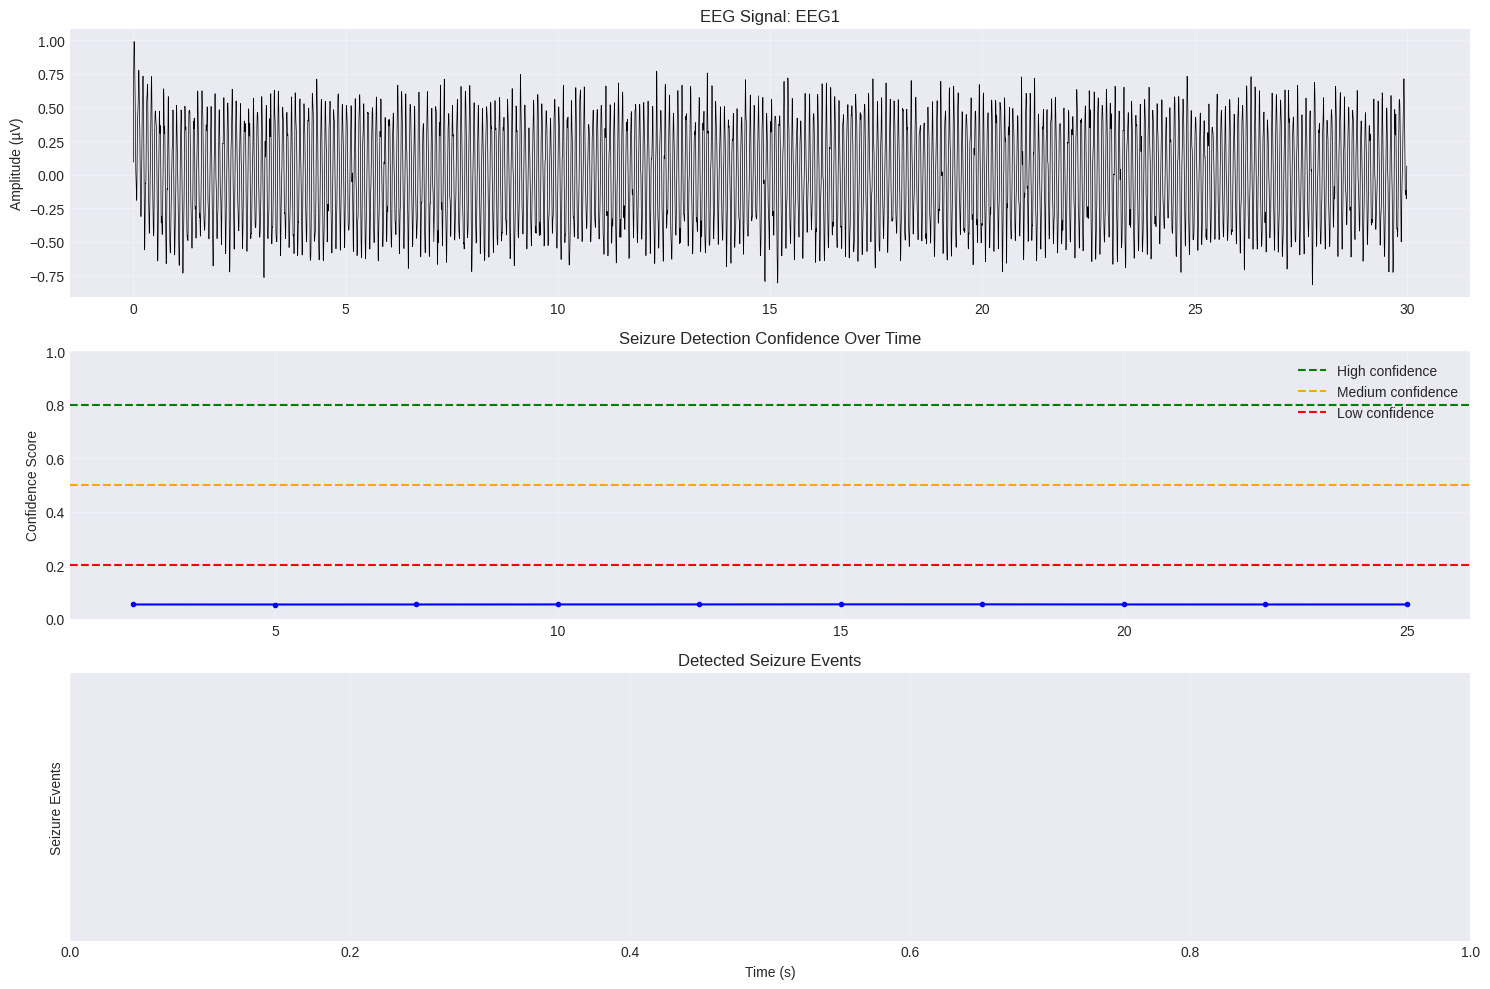

In [10]:
def plot_detection_timeline(results_df: pd.DataFrame, data: np.ndarray, 
                           times: np.ndarray, channel_names: List[str]):
    """Plot detection results over time"""
    fig, axes = plt.subplots(3, 1, figsize=(15, 10))
    
    # Plot 1: EEG signal (first channel)
    axes[0].plot(times, data[0], 'k-', linewidth=0.5)
    axes[0].set_ylabel('Amplitude (µV)')
    axes[0].set_title(f'EEG Signal: {channel_names[0]}')
    axes[0].grid(True, alpha=0.3)
    
    # Highlight seizure windows
    for _, row in results_df[results_df['seizure_detected']].iterrows():
        axes[0].axvspan(row['start_time'], row['end_time'], alpha=0.3, color='red')
    
    # Plot 2: Confidence scores over time
    window_centers = (results_df['start_time'] + results_df['end_time']) / 2
    axes[1].plot(window_centers, results_df['confidence_score'], 'b-', marker='o', markersize=3)
    axes[1].axhline(y=CONFIG['thresholds']['high_confidence'], color='g', linestyle='--', label='High confidence')
    axes[1].axhline(y=CONFIG['thresholds']['medium_confidence'], color='orange', linestyle='--', label='Medium confidence')
    axes[1].axhline(y=CONFIG['thresholds']['low_confidence'], color='r', linestyle='--', label='Low confidence')
    axes[1].set_ylabel('Confidence Score')
    axes[1].set_title('Seizure Detection Confidence Over Time')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim(0, 1)
    
    # Plot 3: Detected seizure types
    seizure_detections = results_df[results_df['seizure_detected']]
    if len(seizure_detections) > 0:
        seizure_types = seizure_detections['seizure_type'].unique()
        colors = plt.cm.Set3(np.linspace(0, 1, len(seizure_types)))
        type_to_color = dict(zip(seizure_types, colors))
        
        for _, row in seizure_detections.iterrows():
            axes[2].barh(0, row['end_time'] - row['start_time'], 
                        left=row['start_time'], height=0.8,
                        color=type_to_color[row['seizure_type']],
                        label=row['seizure_type'])
        
        # Remove duplicate labels
        handles, labels = axes[2].get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        axes[2].legend(by_label.values(), by_label.keys(), loc='upper right')
    
    axes[2].set_xlabel('Time (s)')
    axes[2].set_ylabel('Seizure Events')
    axes[2].set_title('Detected Seizure Events')
    axes[2].set_ylim(-0.5, 0.5)
    axes[2].set_yticks([])
    axes[2].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()

# Generate visualization
plot_detection_timeline(results_df, data_clean, loader.times, loader.channel_names)

## 9. Export Results

Export detection results and generate final report

In [11]:
def export_results(results_df: pd.DataFrame, report: Dict, output_prefix: str = 'seizure_detection'):
    """Export results to files"""
    
    # Save detailed window results
    csv_path = f"{output_prefix}_windows.csv"
    results_df.to_csv(csv_path, index=False)
    print(f"✓ Saved detailed results to {csv_path}")
    
    # Save event summary
    if report['seizure_events']:
        events_df = pd.DataFrame(report['seizure_events'])
        events_path = f"{output_prefix}_events.csv"
        events_df.to_csv(events_path, index=False)
        print(f"✓ Saved seizure events to {events_path}")
    
    # Generate text report
    report_path = f"{output_prefix}_report.txt"
    with open(report_path, 'w') as f:
        f.write("="*70 + "\n")
        f.write("SEIZURE DETECTION ANALYSIS REPORT\n")
        f.write("="*70 + "\n\n")
        
        f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write("CONFIGURATION:\n")
        f.write("-"*70 + "\n")
        for key, value in CONFIG.items():
            f.write(f"{key}: {value}\n")
        f.write("\n")
        
        f.write("SUMMARY:\n")
        f.write("-"*70 + "\n")
        f.write(f"Total Recording Duration: {report['total_duration']:.2f} seconds\n")
        f.write(f"Total Windows Analyzed: {report['total_windows']}\n")
        f.write(f"Windows with Seizure Activity: {report['seizures_detected']}\n")
        f.write(f"Detection Rate: {report['detection_rate']:.2%}\n")
        f.write(f"Number of Seizure Events: {report['num_events']}\n\n")
        
        if report['seizure_events']:
            f.write("DETECTED SEIZURE EVENTS:\n")
            f.write("-"*70 + "\n")
            for i, event in enumerate(report['seizure_events'], 1):
                f.write(f"\nEvent {i}:\n")
                f.write(f"  Seizure Type: {event['seizure_type']}\n")
                f.write(f"  Start Time: {event['start_time']:.2f}s\n")
                f.write(f"  End Time: {event['end_time']:.2f}s\n")
                f.write(f"  Duration: {event['duration']:.2f}s\n")
                f.write(f"  Hemisphere: {event['hemisphere']}\n")
                f.write(f"  Confidence: {event['max_confidence']:.2%}\n")
        else:
            f.write("\nNo seizure events detected.\n")
    
    print(f"✓ Saved report to {report_path}")
    print("\nExport complete!")

# Export results
export_results(results_df, report, output_prefix='seizure_detection_test')

✓ Saved detailed results to seizure_detection_test_windows.csv
✓ Saved report to seizure_detection_test_report.txt

Export complete!


## 10. Quick Testing Interface

Easy interface to test different algorithm combinations

In [12]:
def quick_test_pipeline(data_source: str = 'sample',
                       edf_path: str = None,
                       filter_type: str = 'butterworth',
                       feature_method: str = 'welch',
                       pattern_algorithm: str = 'cosine_similarity',
                       window_size: float = 5.0,
                       high_threshold: float = 0.80):
    """
    Quick test of the full pipeline with custom parameters
    
    Parameters:
    -----------
    data_source : str
        'sample', 'edf', or 'numpy'
    edf_path : str
        Path to EDF file if data_source='edf'
    filter_type : str
        'butterworth', 'fir', or 'iir'
    feature_method : str
        'welch', 'fft', or 'multitaper'
    pattern_algorithm : str
        'cosine_similarity', 'euclidean', 'dtw', or 'correlation'
    window_size : float
        Window size in seconds
    high_threshold : float
        High confidence threshold (0-1)
    """
    
    print("\n" + "="*70)
    print("QUICK PIPELINE TEST")
    print("="*70)
    
    # Update configuration
    test_config = CONFIG.copy()
    test_config['preprocessing']['filter_type'] = filter_type
    test_config['feature_extraction']['frequency_method'] = feature_method
    test_config['pattern_matching']['algorithm'] = pattern_algorithm
    test_config['pattern_matching']['window_size'] = window_size
    test_config['thresholds']['high_confidence'] = high_threshold
    
    print(f"\nConfiguration:")
    print(f"  Data source: {data_source}")
    print(f"  Filter: {filter_type}")
    print(f"  Feature extraction: {feature_method}")
    print(f"  Pattern matching: {pattern_algorithm}")
    print(f"  Window size: {window_size}s")
    print(f"  High confidence threshold: {high_threshold}")
    
    # Load data
    print("\n[1/5] Loading data...")
    test_loader = EEGDataLoader()
    if data_source == 'edf' and edf_path:
        test_loader.load_from_edf(edf_path)
    else:
        test_loader.create_sample_data(add_seizure=True)
    
    # Preprocess
    print("\n[2/5] Preprocessing...")
    test_preprocessor = Preprocessor(test_config['preprocessing'])
    test_data_clean = test_preprocessor.preprocess(test_loader.data, test_loader.sfreq)
    
    # Setup components
    print("\n[3/5] Setting up analysis components...")
    test_localizer = ChannelLocalizer(test_loader.channel_names)
    test_extractor = FeatureExtractor(test_config['feature_extraction'], test_loader.sfreq)
    test_db = SeizurePrototypeDatabase()
    test_matcher = PatternMatcher(test_config['pattern_matching'], test_db)
    
    # Analyze
    print("\n[4/5] Running analysis...")
    test_analyzer = SlidingWindowAnalyzer(
        window_size=window_size,
        overlap=0.5,
        sfreq=test_loader.sfreq,
        extractor=test_extractor,
        matcher=test_matcher,
        localizer=test_localizer
    )
    test_results = test_analyzer.analyze_recording(test_data_clean)
    test_report = test_analyzer.generate_report(test_results)
    
    # Display results
    print("\n[5/5] Results:")
    print("="*70)
    print(f"Seizure events detected: {test_report['num_events']}")
    print(f"Detection rate: {test_report['detection_rate']:.2%}")
    
    for i, event in enumerate(test_report['seizure_events'], 1):
        print(f"\n  Event {i}: {event['seizure_type']}")
        print(f"    Time: {event['start_time']:.1f}-{event['end_time']:.1f}s")
        print(f"    Confidence: {event['max_confidence']:.2%}")
    
    print("\n" + "="*70)
    return test_results, test_report

# Example: Test with different configurations
print("\nTesting pipeline with default settings:")
test_results, test_report = quick_test_pipeline()

# Uncomment to test with different parameters:
# test_results, test_report = quick_test_pipeline(
#     window_size=3.0,
#     high_threshold=0.70
# )


Testing pipeline with default settings:

QUICK PIPELINE TEST

Configuration:
  Data source: sample
  Filter: butterworth
  Feature extraction: welch
  Pattern matching: cosine_similarity
  Window size: 5.0s
  High confidence threshold: 0.8

[1/5] Loading data...
✓ Created sample data: 19 channels, 30.00s duration
  Synthetic seizure added at 10-20s

[2/5] Preprocessing...
Preprocessing...
  Bandpass filter: 0.5-40.0 Hz
  Notch filter: 60.0 Hz
  Using ICA artifact removal (placeholder)
✓ Preprocessing complete

[3/5] Setting up analysis components...

[4/5] Running analysis...

[5/5] Results:
Seizure events detected: 0
Detection rate: 0.00%



## Next Steps

### When Your Data Becomes Available:

1. **Load Your Data**: Update the data loading section (Section 1) to load from your database
2. **Train Prototypes**: Use your labeled seizure data to create better prototypes (Section 5)
3. **Optimize Thresholds**: Adjust confidence thresholds based on validation data
4. **Test Algorithms**: Use the `quick_test_pipeline()` function to compare different algorithms

### Algorithm Customization:

- Modify `CONFIG` dictionary to switch algorithms
- Add new preprocessing methods to `Preprocessor` class
- Add new feature extraction methods to `FeatureExtractor` class
- Add new pattern matching algorithms to `PatternMatcher` class

### Example Usage:

```python
# Load your actual data
loader = EEGDataLoader()
loader.load_from_edf('/path/to/your/seizure_recording.edf')

# Run full pipeline
results, report = quick_test_pipeline(
    data_source='edf',
    edf_path='/path/to/your/seizure_recording.edf',
    window_size=5.0,
    high_threshold=0.80
)

# Export results
export_results(results, report, output_prefix='patient_001_session_01')
```